# Imports and settings

In [362]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

In [363]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)

# Loading Data

In [364]:
#Importing data
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Labeling data
train_a['building_id'] = 'a'
train_b['building_id'] = 'b'
train_c['building_id'] = 'c'

X_train_estimated_a['building_id'] = 'a'
X_train_estimated_b['building_id'] = 'b'
X_train_estimated_c['building_id'] = 'c'

X_train_observed_a['building_id'] = 'a'
X_train_observed_b['building_id'] = 'b'
X_train_observed_c['building_id'] = 'c'

X_test_estimated_a['building_id'] = 'a'
X_test_estimated_b['building_id'] = 'b'
X_test_estimated_c['building_id'] = 'c'

# Combining data
all_observed_X = pd.concat([X_train_observed_a,X_train_observed_b,X_train_observed_c])
all_estimated_X = pd.concat([X_train_estimated_a,X_train_estimated_b,X_train_estimated_c])
all_y = pd.concat([train_a, train_b, train_c])
X_test = pd.concat([X_test_estimated_a,X_test_estimated_b,X_test_estimated_c])

# add type of weather data
all_observed_X['type'] = 'observed'
all_estimated_X['type'] = 'estimated'
X_test['type'] = 'estimated'

# Combining training data
all_X = pd.concat([all_observed_X,all_estimated_X])

# Aggregating all_X
all_X_aggregated = all_X.copy()
all_X_aggregated['time_hour'] = all_X_aggregated['date_forecast'].dt.floor('H')
all_X_aggregated = all_X_aggregated.groupby(['building_id','time_hour','type']).mean().reset_index()

# Aggregating X_test
X_test_aggregated = X_test.copy()
X_test_aggregated['time_hour'] = X_test_aggregated['date_forecast'].dt.floor('H')
X_test_aggregated = X_test_aggregated.groupby(['building_id','time_hour','type']).mean().reset_index()

# Renaming time column in all_y
all_y = all_y.rename(columns={'time': 'time_hour'})

# Merging all_X_aggregated and all_y
all_train = pd.merge(all_X_aggregated,all_y,on=['building_id','time_hour'],how='right') # right join to keep all y values

# 

# Data Analysis

## Preprocessing for Data Analysis

In [365]:
# define groups of variables

sun_features_list = ['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'is_day:idx', 'is_in_shadow:idx', 'sun_elevation:d']

humidity_features_list = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'dew_point_2m:K', 't_1000hPa:K']

snow_features_list = ['fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm']

cloud_height_features_list = ['ceiling_height_agl:m', 'cloud_base_agl:m']

feature_groups = [
    {
        'name': 'sun',
        'features': sun_features_list
    },
    {
        'name': 'humidity',
        'features': humidity_features_list
    },
    {
        'name': 'snow',
        'features': snow_features_list
    },
    {
        'name': 'cloud_height',
        'features': cloud_height_features_list
    }
]

all_pca_features = sun_features_list + humidity_features_list + snow_features_list + cloud_height_features_list

In [366]:
all_data = all_X_aggregated.merge(all_y,on=['time_hour','building_id'],how='left')

In [367]:
all_data.describe()

,time_hour,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc,pv_measurement
count,101290,101290,101290.000000,101290.000000,84120.000000,1.012900e+05,101290.000000,94051.000000,101290.000000,101290.000000,101290.000000,1.012900e+05,101290.000000,1.012900e+05,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,6313.0,101290.000000,101290.000000,101290.00000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,101290.000000,13182,92951.000000
mean,2021-02-09 19:20:04.999506176,2021-02-09 19:42:34.959522816,5.975971,1.255952,2813.539795,5.192933e+05,144.248108,1725.593018,0.001644,275.074524,39.752518,1.431091e+05,50.426682,1.815363e+05,67.129250,12.303140,0.142881,0.011886,0.282510,0.035736,0.071435,0.483908,0.565974,1009.473022,0.005627,0.084586,995.656799,1001.790100,0.869761,0.009360,73.630493,1007.950562,250.0,0.329476,0.000027,0.00039,0.088631,179.601883,-1.133386,0.056661,279.324554,73.708656,33041.195312,3.018733,0.656914,0.689075,0.000041,2023-01-27 19:07:13.160673536,287.232321
min,2019-01-01 00:00:00,2019-01-01 00:22:30,0.500000,1.139250,27.600000,0.000000e+00,0.000000,27.299997,-1.000000,247.425003,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,944.375000,0.000000,0.000000,929.974976,935.750000,0.000000,0.000000,19.575001,941.549988,250.0,0.000000,0.000000,0.00000,0.000000,6.983000,-49.931999,0.000000,258.024994,0.000000,132.375000,0.025000,-7.225000,-8.400000,-0.100000,2022-10-27 07:00:18,-0.000000
25%,2020-02-07 16:00:00,2020-02-07 16:22:30,3.950000,1.230312,1065.162598,0.000000e+00,0.000000,605.087524,0.000000,270.500000,0.000000,0.000000e+00,0.000000,0.000000e+00,42.125000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1001.400024,0.000000,0.000000,987.674988,993.750000,0.000000,0.000000,64.125000,999.849976,250.0,0.000000,0.000000,0.00000,0.000000,94.567251,-18.524750,0.000000,274.725006,53.224999,17162.319336,1.675000,-1.350000,-0.575000,0.000000,2022-12-12 08:00:05,0.000000
50%,2021-01-24 08:30:00,2021-01-24 08:52:30,5.400000,1.255500,1850.599976,1.064944e+04,1.725000,1172.175049,0.000000,274.824982,0.975000,1.066409e+04,0.000000,0.000000e+00,80.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,1.000000,1010.299988,0.000000,0.000000,996.525024,1002.650024,0.000000,0.000000,76.000000,1008.775024,250.0,0.000000,0.000000,0.00000,0.000000,179.980499,-0.811375,0.000000,278.549988,93.050003,36854.912109,2.675000,0.300000,0.750000,0.000000,2023-01-28 08:00:04,0.000000
75%,2022-01-11 01:00:00,2022-01-11 01:22:30,7.825000,1.279500,3825.656250,8.083140e+05,220.243752,2079.937500,0.000000,280.524994,66.175003,2.374326e+05,29.350000,1.143168e+05,98.650002,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1018.424988,0.000000,0.000000,1004.650024,1010.775024,0.000000,0.000000,85.074997,1016.950012,250.0,0.000000,0.000000,0.00000,0.100000,264.4099

## Univariable study

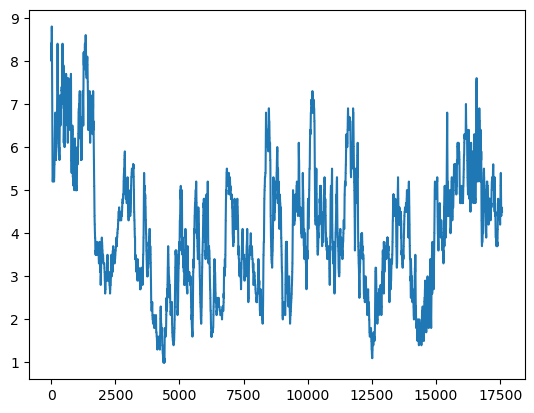

In [368]:

#absolute_humidity_2m:gm3 -> Absolute humidity at 2m level [g/m3]
plt.plot(X_train_estimated_a['absolute_humidity_2m:gm3']) #continuous values 

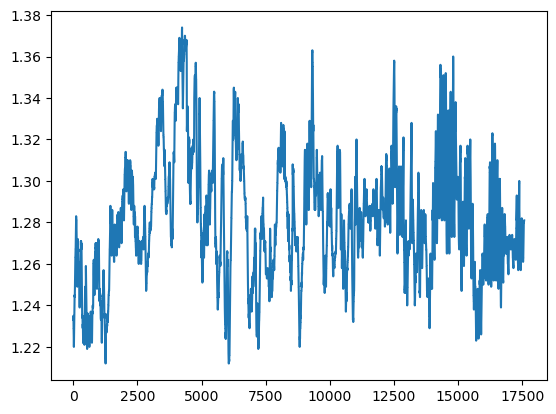

In [369]:
#air_density_2m:kgm3 -> atmospheric air density at 2m lvl [kg/m3]
plt.plot(X_train_estimated_a['air_density_2m:kgm3']) #continuous values 

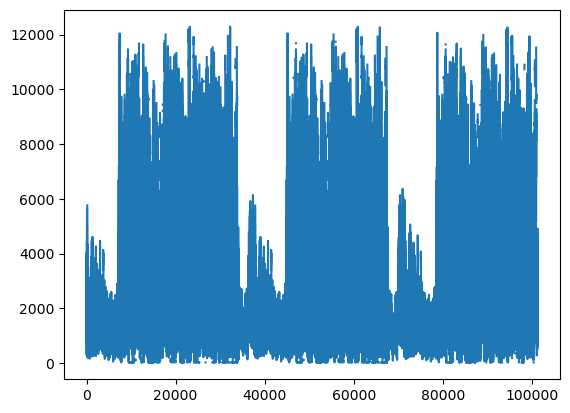

In [370]:
#ceiling_height_agl:m -> cloud height above ground level
plt.plot(all_data['ceiling_height_agl:m']) #continuous values 

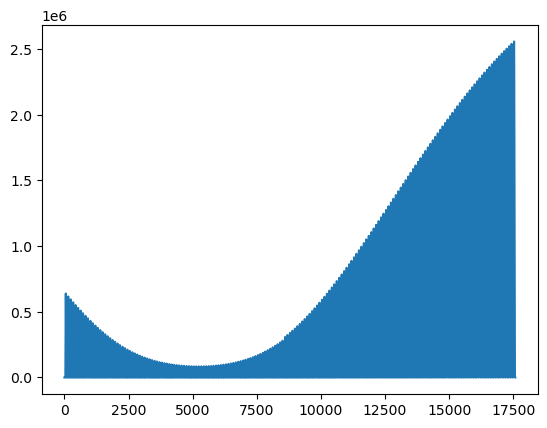

In [371]:
#clear_sky_energy_1h:J -> how much energy in 1h of clear sky
plt.plot(X_train_estimated_a['clear_sky_energy_1h:J']) # Seasonality?

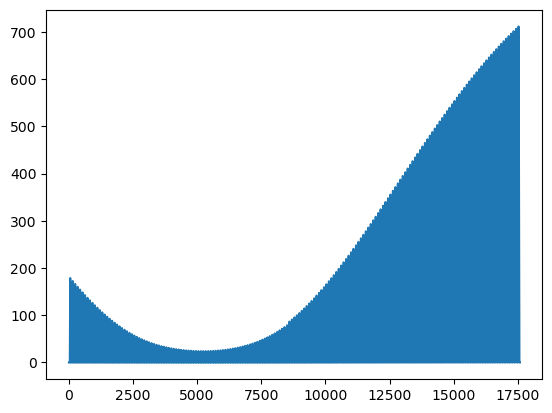

In [372]:
#clear_sky_rad:W -> how much radiation in 1h of clear sky
plt.plot(X_train_estimated_a['clear_sky_rad:W']) # Seasonality? Same as previous?

,building_id,time_hour,type,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc,pv_measurement
134,a,2019-06-08 12:00:00,observed,2019-06-08 12:22:30,10.475,1.18850,NaN,2.952455e+06,806.349976,NaN,0.0,285.350006,122.724998,494558.312500,588.549988,2.068820e+06,20.975000,6.0,0.0,0.0,0.000,0.0,0.0,1.00,0.0,1009.924988,0.0,0.0,997.099976,1002.974976,0.000000,0.0,63.599998,1008.875000,NaN,0.0,0.0,0.0,0.0,202.818253,47.820000,0.0,290.649994,37.799999,49054.523438,4.775,-3.25,-3.500,0.0,NaT,4457.86
135,a,2019-06-08 13:00:00,observed,2019-06-08 13:22:30,10.875,1.18550,NaN,2.811238e+06,749.924988,NaN,0.0,285.950012,122.474998,441355.687500,524.575012,2.003657e+06,16.475000,6.0,0.0,0.0,0.000,0.0,0.0,1.00,0.0,1009.349976,0.0,0.0,996.575012,1002.424988,0.000000,0.0,64.250000,1008.325012,NaN,0.0,0.0,0.0,0.0,222.152252,44.224251,0.0,291.399994,27.200001,48945.500000,5.325,-3.40,-4.100,0.0,NaT,4289.34
269,a,2019-06-14 03:00:00,observed,2019-06-14 03:22:30,9.500,1.22800,NaN,2.122680e+05,95.275002,NaN,0.0,283.549988,53.325001,131935.656250,24.150000,6.678812e+04,45.250000,6.0,0.0,0.0,0.000,0.0,0.0,1.00,0.0,1015.674988,0.0,0.0,1002.950012,1008.950012,0.000000,0.0,76.724998,1015.000000,NaN,0.0,0.0,0.0,0.0,54.207500,8.789750,0.0,286.075012,89.750000,40865.523438,2.150,-2.15,0.000,0.0,NaT,238.26
270,a,2019-06-14 04:00:00,observed,2019-06-14 04:22:30,9.725,1.22175,NaN,5.201684e+05,198.674988,NaN,0.0,283.899994,80.974998,241791.078125,85.750000,1.978096e+05,38.049999,6.0,0.0,0.0,0.000,0.0,0.0,1.00,0.0,1015.674988,0.0,0.0,1002.900024,1008.925049,0.000000,0.0,75.600006,1014.925049,NaN,0.0,0.0,0.0,0.0,67.004501,14.626500,0.0,286.450012,75.150002,43029.425781,1.850,-1.85,-0.150,0.0,NaT,815.10
271,a,2019-06-14 05:00:00,observed,2019-06-14 05:22:30,9.825,1.21475,NaN,9.355038e+05,323.174988,NaN,0.0,284.174988,115.724998,354095.968750,143.199997,4.120919e+05,38.000000,6.0,0.0,0.0,0.000,0.0,0.0,1.00,0.0,1015.799988,0.0,0.0,1003.000000,1009.000000,0.000000,0.0,72.449997,1015.000000,NaN,0.0,0.0,0.0,0.0,79.872002,21.046749,0.0,287.225006,74.375000,45633.625000,1.900,-1.85,-0.300,0.0,NaT,1001.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101074,c,2023-04-22 00:00:00,estimated,2023-04-22 00:22:30,5.025,1.28875,NaN,0.000000e+00,0.000000,NaN,-1.0,273.649994,0.000000,0.000000,0.000000,0.000000e+00,4.400000,24.0,0.0,0.0,0.000,0.0,0.0,0.00,1.0,1018.049988,0.0,0.0,1002.650024,1008.924988,71.375000,0.0,92.099998,1015.224976,NaN,0.0,0.0,0.0,0.0,16.040501,-13.495000,0.0,278.200012,4.400000,22378.300781,1.050,0.10,1.050,0.0,2023-04-21 07:00:59,0.00
101075,c,2023-04-22 01:00:00,estimated,2023-04-22 01:22:30,4.900,1.28975,NaN,0.000000e+00,0.000000,NaN,-1.0,273.399994,0.000000,0.000000,0.000000,0.000000e+00,3.200000,24.0,0.0,0.0,0.000,0.0,0.0,0.00,1.0,1017.549988,0.0,0.0,1002.049988,1008.349976,63.775002,0.0,92.500000,1014.650024,NaN,0.0,0.0,0.0,0.0,30.834499,-10.826750,0.0,277.274994,3.200000,23221.550781,1.050,0.20,1.050,0.0,2023-04-21 07:00:59,0.00
101076,c,2023-04-22 02:00:00,estimated,2023-04-22 02:22:30,4.900,1.28775,NaN,0.000000e+00,0.000000,NaN,-1.0,273.

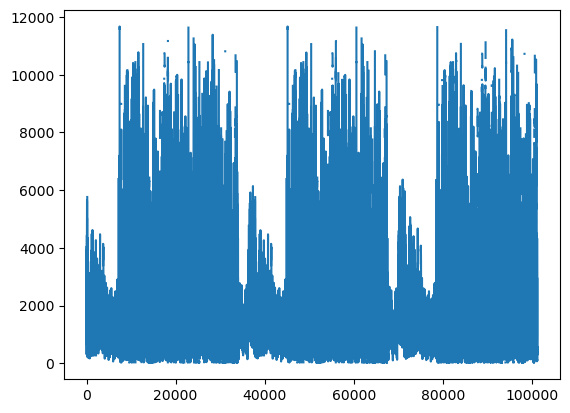

In [373]:
#cloud_base_agl:m -> lowest altitude of visible cloud
plt.plot(all_data['cloud_base_agl:m']) # continuous, correlated to ceiling?
all_data[all_data['cloud_base_agl:m'].isna()]

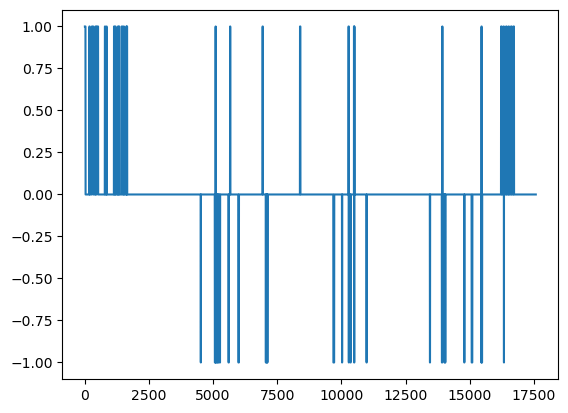

In [374]:
#dew_or_rime:idx -> dew or rime 
plt.plot(X_train_estimated_a['dew_or_rime:idx']) # {1 = dew, -1 = rime, 0 = none}

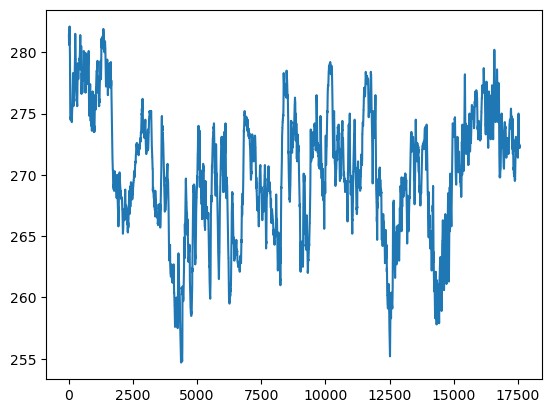

In [375]:
#dew_point_2m:K -> temperature at which the water vapor condenses into liquid
plt.plot(X_train_estimated_a['dew_point_2m:K']) # continuous -> correlated with water vapor in air

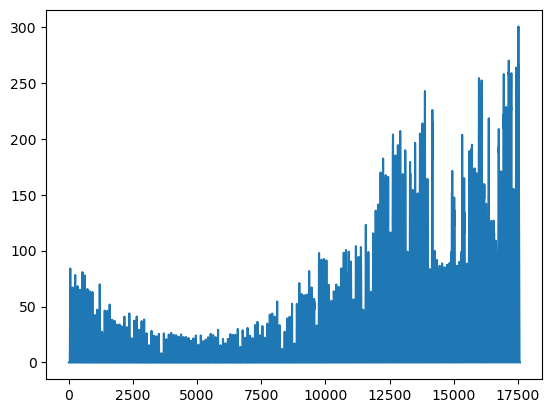

In [376]:
#diffuse_rad:W -> flux of diffuse radiation (not direct solar flux)
plt.plot(X_train_estimated_a['diffuse_rad:W']) # correlated with solar flux

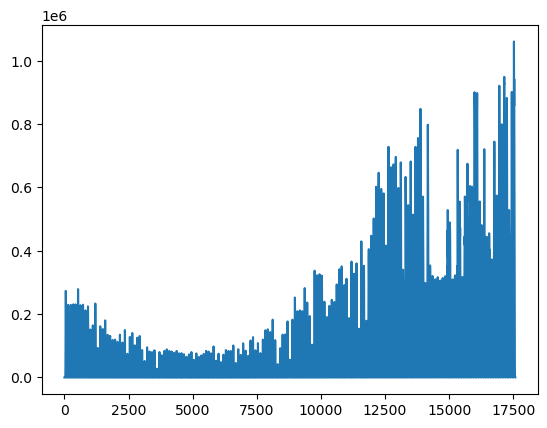

In [377]:
#diffuse_rad_1h:J -> flux of diffuse radiation in 1h
plt.plot(X_train_estimated_a['diffuse_rad_1h:J']) # same as previous?

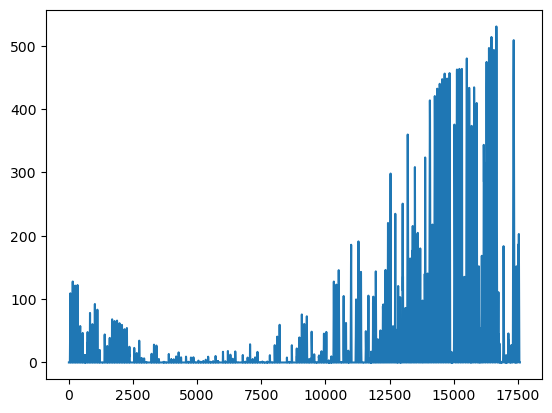

In [378]:
#direct_rad:W -> flux of direct radiation
plt.plot(X_train_estimated_a['direct_rad:W']) # correlated with clear sky

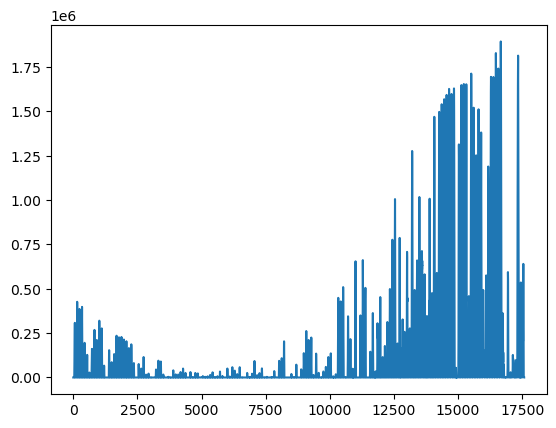

In [379]:
#direct_rad_1h:J -> flux of direct radiation
plt.plot(X_train_estimated_a['direct_rad_1h:J']) # same as previous

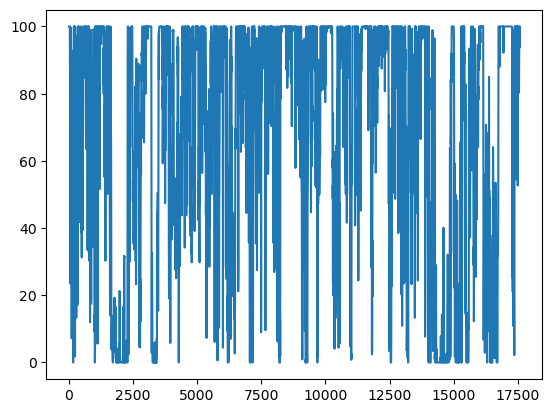

In [380]:
#effective_cloud_cover:p-> cloud covering of the sky !! -666 = no clouds
plt.plot(X_train_estimated_a['effective_cloud_cover:p']) # -666 values

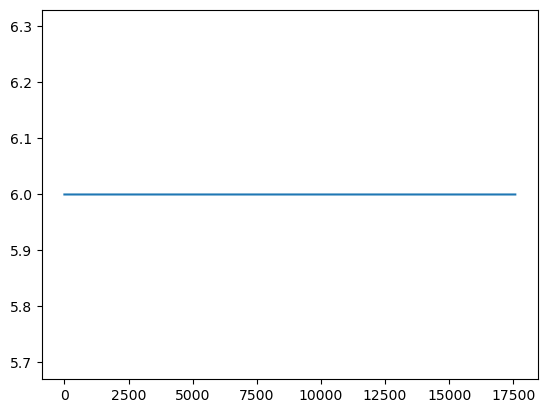

In [381]:
#elevation:m -> elevation of the building 
plt.plot(X_train_estimated_a['elevation:m']) # -const value dor building

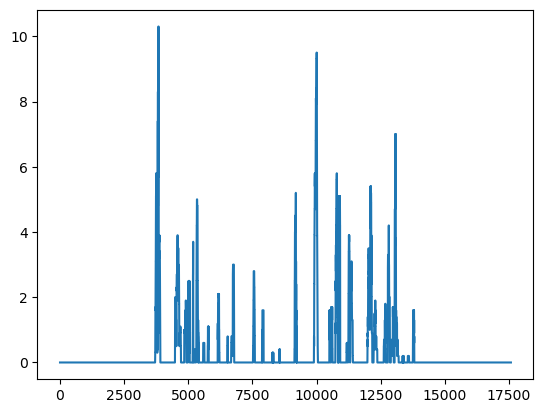

In [382]:
#fresh_snow_12h:cm -> amount in cm of fresh snow in hh hours
plt.plot(X_train_estimated_a['fresh_snow_12h:cm']) # continuous

#same for 12, 24, 1, 3, 6 h -> correlation

In [383]:
#is_day:idx -> if the sun is above horizon, seasonality?
X_train_estimated_a['is_day:idx'] # {0 = below horizon, 1 = above horizion}


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
17571    0.0
17572    0.0
17573    0.0
17574    0.0
17575    0.0
Name: is_day:idx, Length: 17576, dtype: float32

In [384]:
#is_in_shadow:idx -> if the sbuilding is in shadow -> correlation with previous?
X_train_estimated_a['is_in_shadow:idx'] # {0 = not in shadow, 1 = in shadow}

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
17571    1.0
17572    1.0
17573    1.0
17574    1.0
17575    1.0
Name: is_in_shadow:idx, Length: 17576, dtype: float32

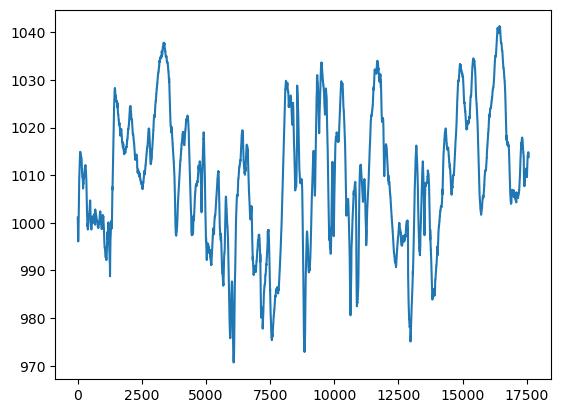

In [385]:
#msl_pressure:hPa -> mean sea level pressure
plt.plot(X_train_estimated_a['msl_pressure:hPa']) # correlation with other pressure misure?

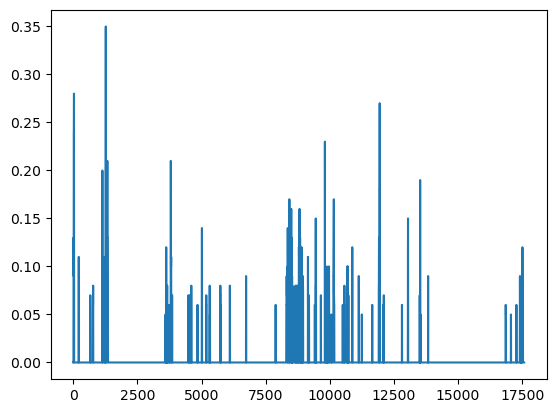

In [386]:
#precip_5min:mm -> rain in 5 min 
plt.plot(X_train_estimated_a['precip_5min:mm']) # 0 or continuous values

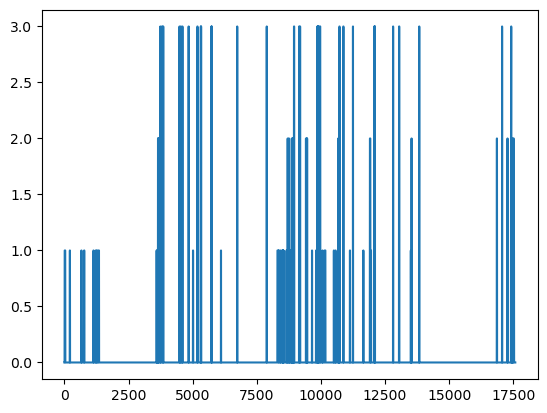

In [387]:
#precip_type_5min:idx -> 6 types of rain 
plt.plot(X_train_estimated_a['precip_type_5min:idx']) # categorical, correlated with precipitaion?
# 0 = None
# 1 = rain
# 2 = rain and snow mixed
# 3 = snow 
# 4 = sleet
# 5 = freezing rain
# 6 = Hail

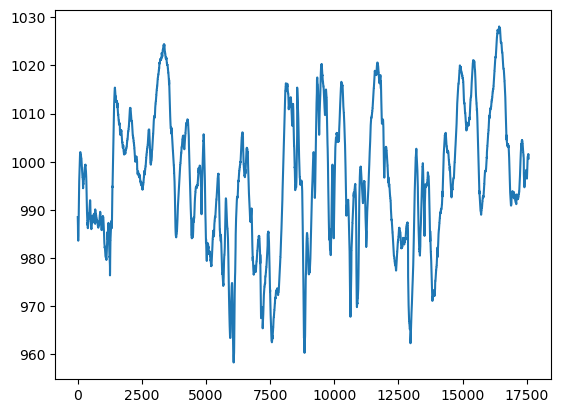

In [388]:
#pressure_100m:hPa -> pressure at x m -> correlated with pressures?
plt.plot(X_train_estimated_a['pressure_100m:hPa']) # continuous

# same for 50 m

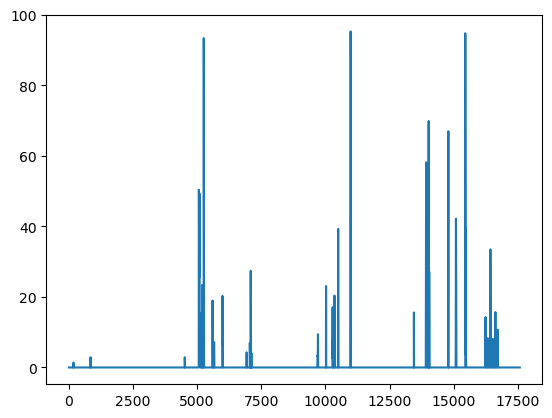

In [389]:
#prob_rime:p -> probability of rime
plt.plot(X_train_estimated_a['prob_rime:p']) # %

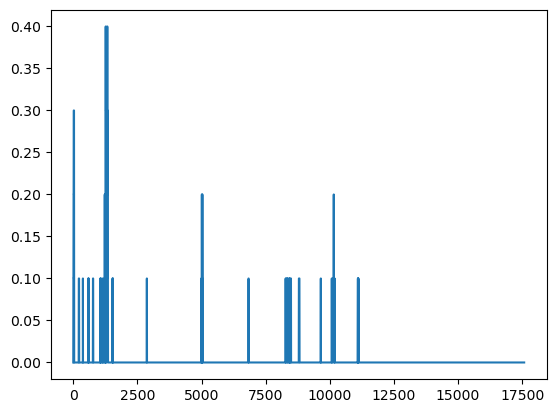

In [390]:
#rain_water:kgm2 -> how much rain in kg/m2
plt.plot(X_train_estimated_a['rain_water:kgm2']) # same as precipitation?

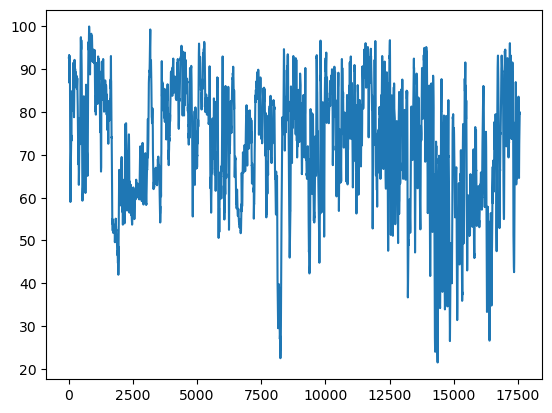

In [391]:
#relative_humidity_1000hPa:p -> humidity correlated with other?
plt.plot(X_train_estimated_a['relative_humidity_1000hPa:p']) # continuous 

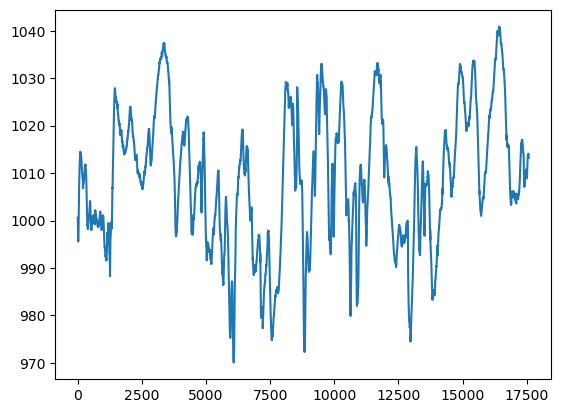

In [392]:
#sfc_pressure:hPa -> surface pressure, related with other pressures?
plt.plot(X_train_estimated_a['sfc_pressure:hPa']) # continuous 

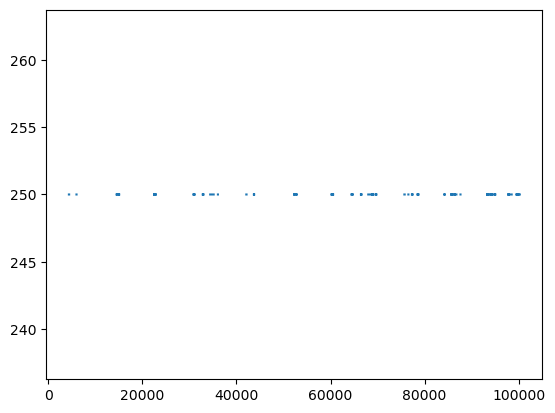

In [393]:
#snow_density:kgm3 -> seems always 250 (not significant?)
plt.plot(all_data['snow_density:kgm3']) # const if snow depth < 60 cm 

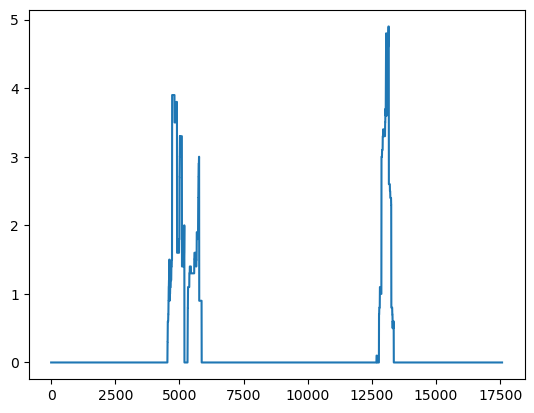

In [394]:
#snow_depth:cm -> snow depth in cm, correlated with snow
plt.plot(X_train_estimated_a['snow_depth:cm']) # 0 or continuous

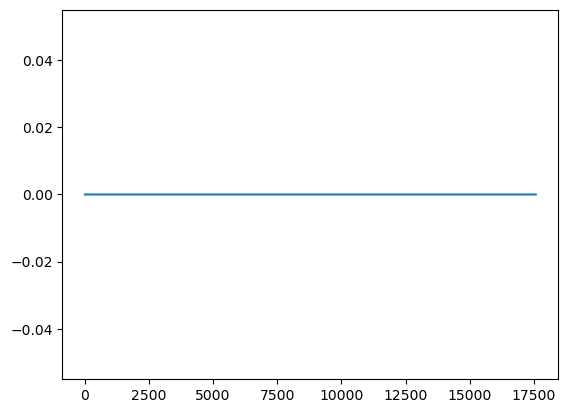

In [395]:
#snow_drift:idx -> index of snow carried over by wind seems always 0 (not significant?)
plt.plot(X_train_estimated_a['snow_drift:idx']) # categorical

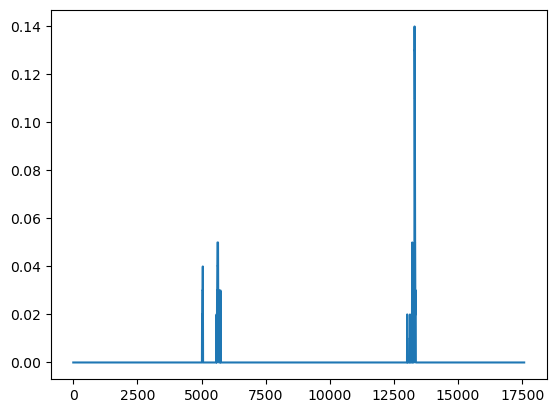

In [396]:
#snow_melt_10min:mm -> mm of melted snow in 10 min, correlated with snow?
plt.plot(X_train_estimated_a['snow_melt_10min:mm']) # 0 or continuous

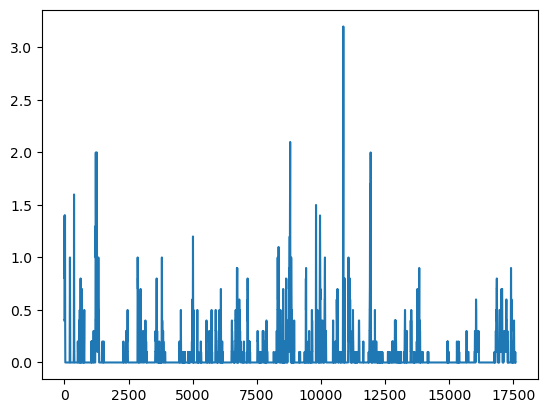

In [397]:
#snow_water:kgm2 -> snow converted in water? correlated with snow? 
plt.plot(X_train_estimated_a['snow_water:kgm2']) # 0 or continuous

<Axes: xlabel='date_forecast', ylabel='sun_azimuth:d'>

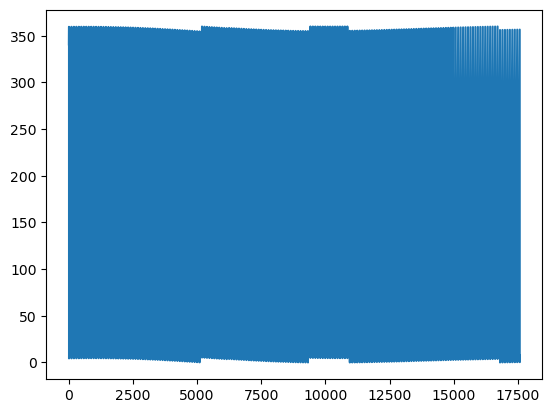

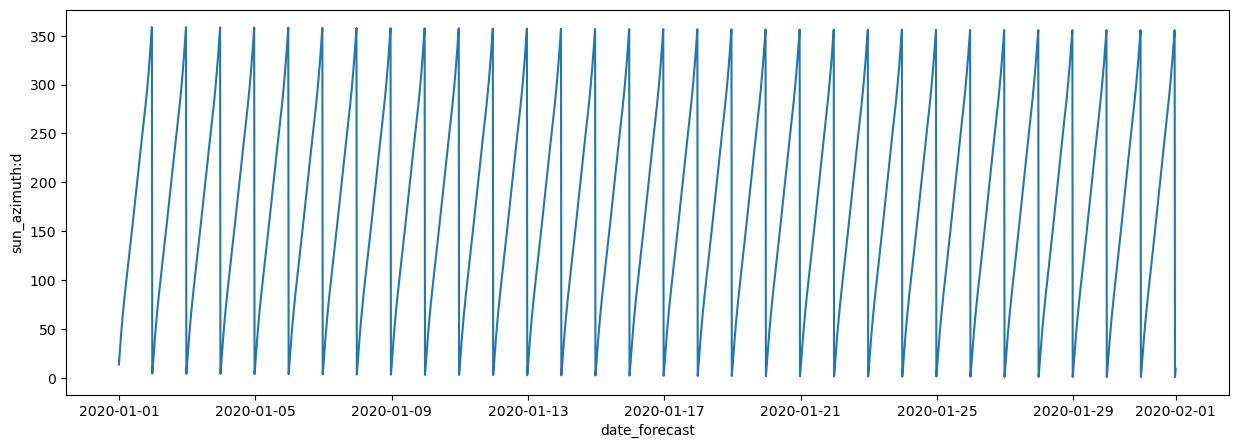

In [398]:
#'sun_azimuth:d' -> sun direction -> seasonality?
plt.plot(X_train_estimated_a['sun_azimuth:d']) # °
plt.figure(figsize=(15,5))
sns.lineplot(data=X_train_observed_a[X_train_observed_a['date_forecast'].between('2020-01-01','2020-02-01')],x='date_forecast',y='sun_azimuth:d')

<Axes: xlabel='date_forecast', ylabel='sun_elevation:d'>

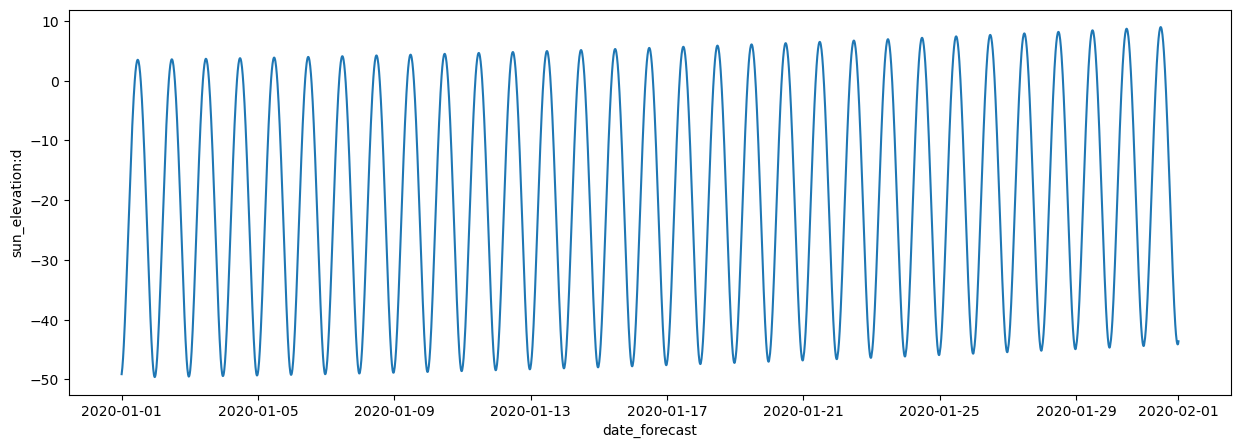

In [399]:
#'sun_elevation:d' -> sun elevation in degree -> seasonality
#plt.plot(X_train_observed_a['sun_elevation:d']) # °
plt.figure(figsize=(15,5))
sns.lineplot(data=X_train_observed_a[X_train_observed_a['date_forecast'].between('2020-01-01','2020-02-01')],x='date_forecast',y='sun_elevation:d')

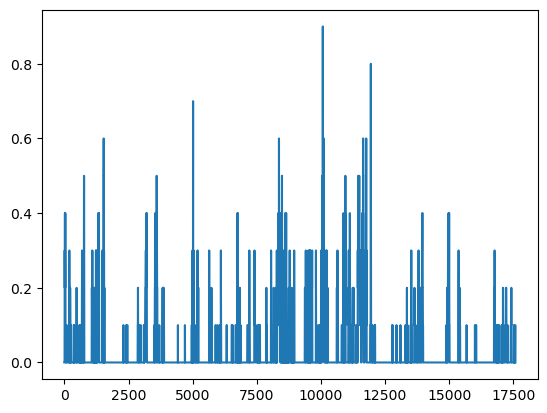

In [400]:
#'super_cooled_liquid_water:kgm2' -> super cooled water (under 0°C ) correlated with rain/snow?
plt.plot(X_train_estimated_a['super_cooled_liquid_water:kgm2']) # 0 or continuous

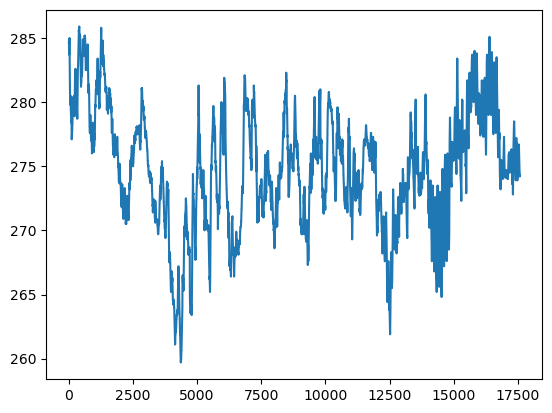

In [401]:
#t_1000hPa:K -> temperature in K 
plt.plot(X_train_estimated_a['t_1000hPa:K']) # continuous

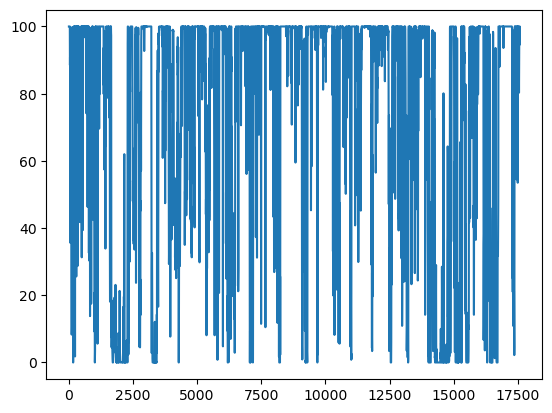

In [402]:
#total_cloud_cover:p -> % of cloud cover correlated with covered sky
plt.plot(X_train_estimated_a['total_cloud_cover:p']) # %

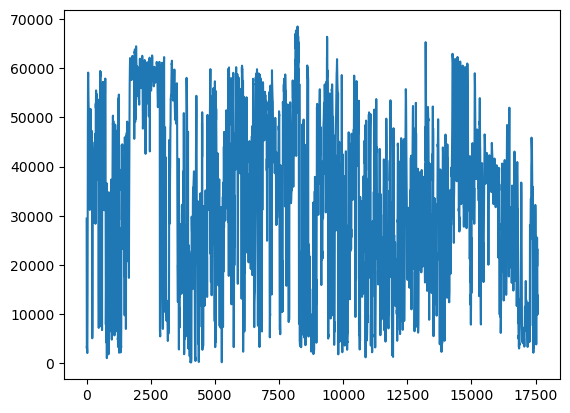

In [403]:
#visibility:m -> visibility in meters
plt.plot(X_train_estimated_a['visibility:m']) # continuous

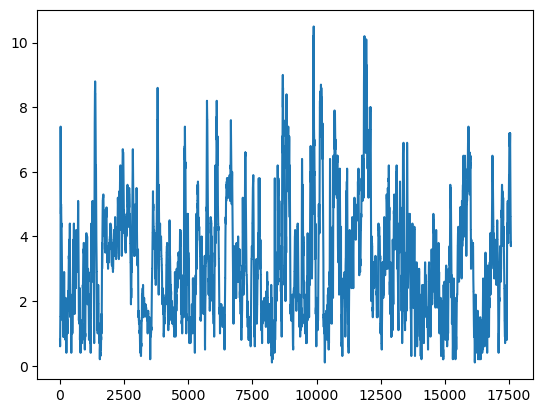

In [404]:
#wind_speed_10m:ms -> wind speed at 10m 
plt.plot(X_train_estimated_a['wind_speed_10m:ms']) # continuous

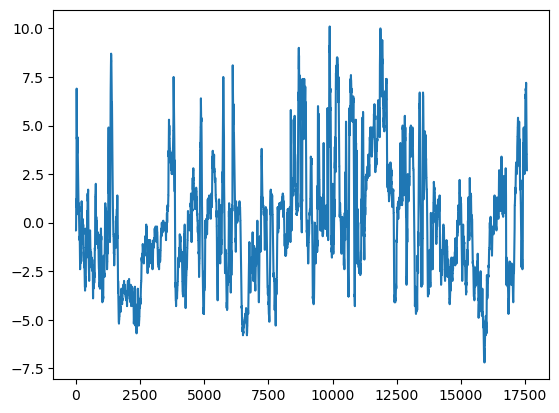

In [405]:
#wind_speed_10m:ms -> wind speed from west to east at 10m 
plt.plot(X_train_estimated_a['wind_speed_u_10m:ms']) # continuous

#same for wind_speed_v_10m:ms from south to north
#both correlated with wind speed?

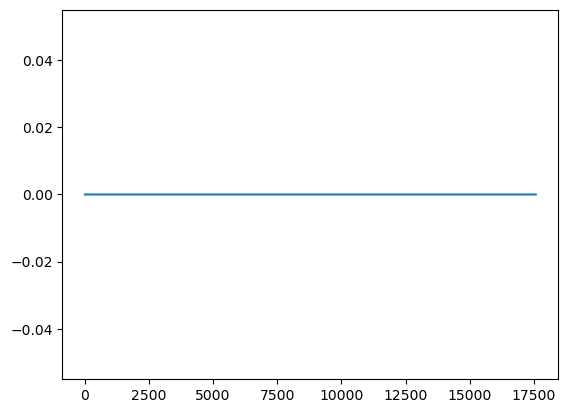

In [406]:
#wind_speed_w_1000hPa:ms -> vertical wind (maybe not significant often 0)
plt.plot(X_train_estimated_a['wind_speed_w_1000hPa:ms']) # continuous

## Correlation analysis

<Axes: >

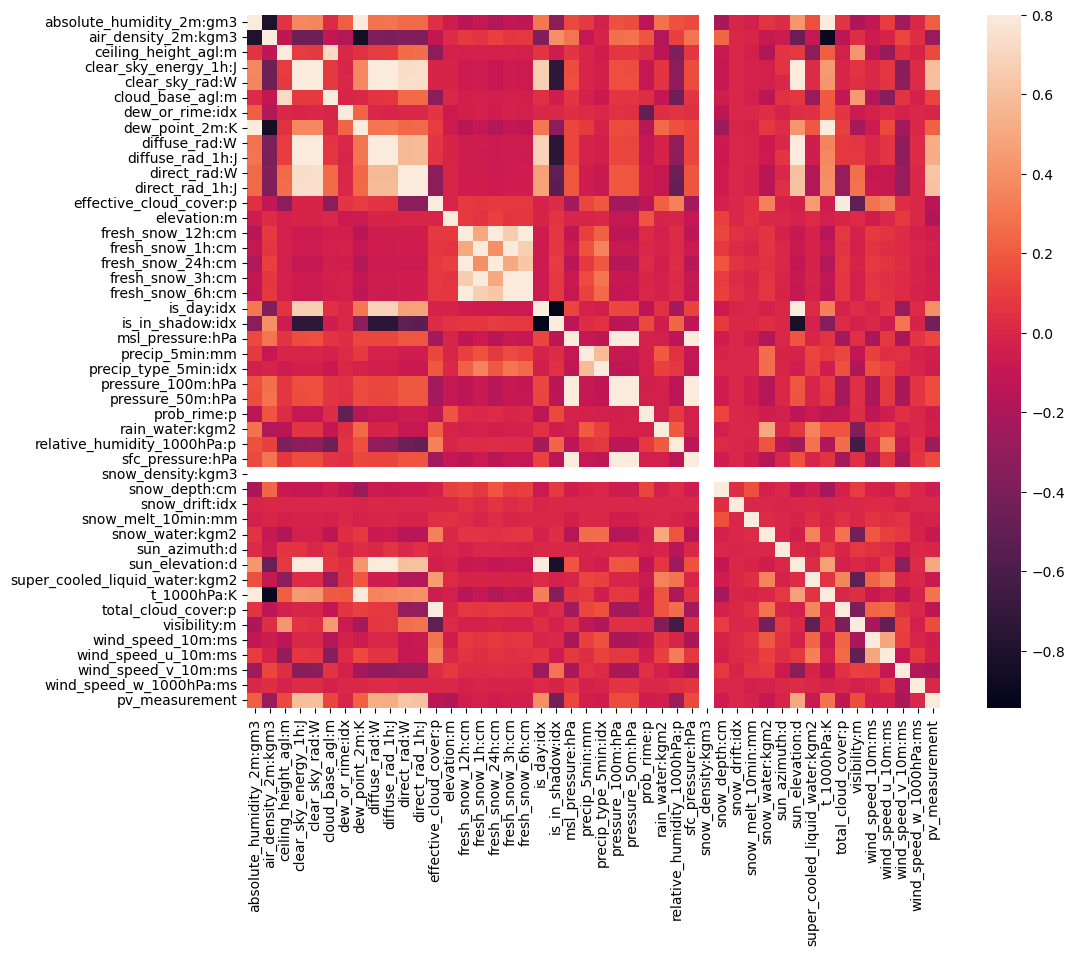

In [407]:
corrmat = all_data.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

## Groups of feature

Some features are really very related to each other as they concern the same phenomenon from different points of view, so it makes sense to merge these groups via PCA

### Humidity group
- absolute_snow_2m:gm3
- air_density_2m:kgm3
- dew_point_2m:K
- t_1000hPa:K

### Cloud height
- ceiling_height_agl:m
- cloud_base_agl:m

### Sun
- clear_sky_energy_1h:J
- clear_sky_rad:W
- diffuse_rad:W
- diffuse_rad_1h:J
- direct_rad:W
- direct_rad_1h:J
- is_day:idx
- is_in_shadow:idx
- sun_elevation:d

### Cloud cover
- effective_cloud_cover:p
- total_cloud_cover:p
- visibility:m (!correlation with many different feature!)

### Snow
- fresh_snow_12h:cm
- fresh_snow_1h:cm
- fresh_snow_24h:cm
- fresh_snow_3h:cm
- fresh_snow_6h:cm

### Pressure
- msl_pressure:hPa
- pressure_100m:hPa
- pressure_50m:hPa
- sfc_pressure:hPa

### Precipitation
- precip_5min:mm
- precip_type_5min:idx

### Rain/Snow Water
- rain_water:kgm2
- snow_water:kgm2

### Wind
- wind_speed_10m:ms
- wind_speed_u_10m:ms
- wind_speed_v_10m:ms
- wind_speed_w_1000hPa:ms

## Other comments on feature that are not in group

### dew_or_rime:idx
index that explains whether there is dew, rime or neither
correlation with prob_rime:p

### elevation:m
Is constant for every building so probably is not significant to do previsions (could it be used as a categorical to classify the three buildings?)

### relative_humidity_1000hPa:p
why is it not correlated with the other humidity indices? there is correlation with the 'Sun' group

### snow_density:kgm3
Not significant because snow depth is always < 60cm

### snow_depth:cm
Very often it is zero, it could be of little significance

### snow_melt_10min:mm
Very often it is zero, it could be of little significance

### sun_azimuth:d
It seems to be unrelated to anything. To be studied better

### super_cooled_liquid_water:kgm2
Some correlation with cloud cover group

### Visibility
This feature is related to many groups, we need to understand how to treat it


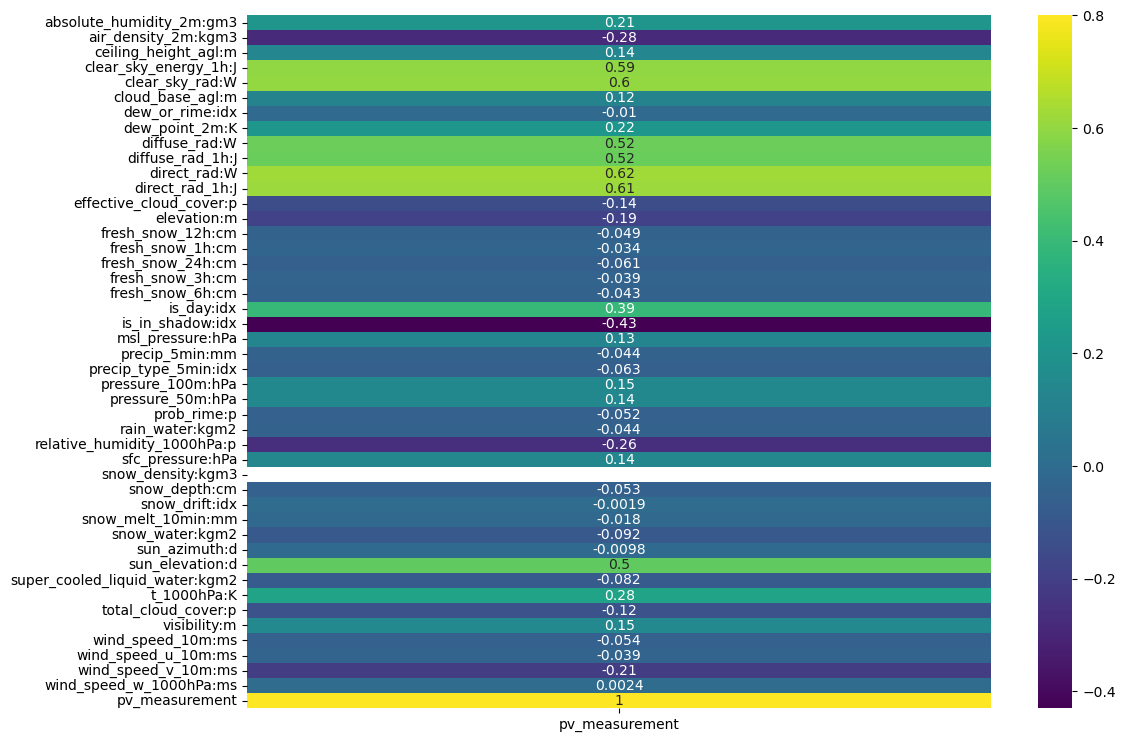

In [408]:
corr_y = all_data.corr(numeric_only=True)['pv_measurement'].to_frame()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_y, vmax=.8, cmap='viridis', annot=True);

# Pre-Processing

### Data cleaning

In [409]:
all_data.dtypes

building_id                               object
time_hour                         datetime64[ns]
type                                      object
date_forecast                     datetime64[ns]
absolute_humidity_2m:gm3                 float32
air_density_2m:kgm3                      float32
ceiling_height_agl:m                     float32
clear_sky_energy_1h:J                    float32
clear_sky_rad:W                          float32
cloud_base_agl:m                         float32
dew_or_rime:idx                          float32
dew_point_2m:K                           float32
diffuse_rad:W                            float32
diffuse_rad_1h:J                         float32
direct_rad:W                             float32
direct_rad_1h:J                          float32
effective_cloud_cover:p                  float32
elevation:m                              float32
fresh_snow_12h:cm                        float32
fresh_snow_1h:cm                         float32
fresh_snow_24h:cm   

In [410]:
# drop non useful features
drop_features = [
    'snow_density:kgm3', # always 250 or nan
    'date_calc', # TODO put dates back in, only for testing
    'date_forecast', # TODO
    'time_hour' # TODO
]

all_data = all_data.drop(columns=drop_features)

In [411]:
# define columns to impute
impute_features = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
]

# Modeling

In [412]:
from sklearn.exceptions import NotFittedError

class PCA_Transformer:
    def __init__(self,feature_groups,target_column):
        self.min_abs_corr = 0
        self.feature_groups = feature_groups
        self.target_column = target_column
        self.fitted = False

    def set_params(self, **params):
        self.min_abs_corr = params.get('min_abs_corr')

    def transform(self, input_df, **transform_params):
        print('TEST 2')

        if not self.fitted:
            raise NotFittedError()
        
        for i, feature_group in enumerate(self.feature_groups):

            # extract feature group name and features
            name = feature_group.get('name')
            features = feature_group.get('features')
            scaler = feature_group.get('scaler')
            pca_transformer = feature_group.get('pca_transformer')
            relevant_features = feature_group.get('relevant_features')

            # make sure that features have no empty values
            if input_df[features].isna().any().any():
                raise ValueError(f'Features {features} have empty values')

            # scale features
            X_features_scaled = scaler.transform(input_df[features])

            # perform PCA
            X_pca = pd.DataFrame(
                pca_transformer.transform(X_features_scaled))
            X_pca.columns = [name + "_pca_" +
                             str(i+1) for i in range(X_pca.shape[1])]

            # keep only features with correlation above threshold
            X_pca = X_pca.loc[:,relevant_features]

            # drop original features
            input_df = input_df.drop(features, axis=1)

            # combine PCA features with original dataframe
            input_df = pd.concat([input_df, pd.DataFrame(X_pca)], axis=1)

        return input_df
            

    def fit(self, X, y=None, **fit_params):
        X = X.copy() # just to be sure
        for i, feature_group in enumerate(self.feature_groups):
            
            # extract feature group name and features
            name = feature_group.get('name')
            features = feature_group.get('features')

            # get only columns that are still in the dataframe
            features = [col for col in features if col in X.columns]

            # make sure that features have no empty values
            if X[features].isna().any().any():
                raise ValueError(f'Features {features} have empty values')
            
            # scale features
            scaler = StandardScaler()
            X_features_scaled = scaler.fit_transform(X[features])

            # perform PCA
            pca_transformer = PCA()
            X_pca = pd.DataFrame(pca_transformer.fit_transform(X_features_scaled))
            X_pca.columns = [name + "_pca_" + str(i+1) for i in range(X_pca.shape[1])]


            # calculate correlation between PCA features and target
            correlation = X_pca.corrwith(self.target_column.abs()).reset_index(drop=True) # feature names are not important, only the index

            # select only features with correlation above threshold
            print(correlation[correlation >=
                  self.min_abs_corr].index.to_list()) # TODO:remove
            relevant_features = correlation[correlation >= self.min_abs_corr].to_list() # we take the individual features instead of just n_components for the case that e.g. sun_4 is higher correlated than sun_3 --> this gives a boolean array for the pca features

            # save results
            self.feature_groups[i]['features'] = features # if some features are not in df anymore
            self.feature_groups[i]['scaler'] = scaler
            self.feature_groups[i]['pca_transformer'] = pca_transformer
            self.feature_groups[i]['relevant_features'] = relevant_features
        
        self.fitted = True
        return self

In [413]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from skopt.space import Real, Categorical, Integer

estimators = [
    {
        "estimator": RandomForestRegressor(
            #criterion="MAE",
            n_jobs=-1,
            random_state=42
        ),
        "parameters": {
            'estimator__n_estimators': Integer(10, 200),
            'estimator__max_depth': Integer(2, 10),
            #'estimator__min_samples_split': Integer(2, 10),
            #'estimator__min_samples_leaf': Integer(1, 10),
            #'estimator__min_weight_fraction_leaf': Real(0, 0.5),
            #'estimator__max_features': Categorical(['auto', 'sqrt', 'log2']),
            #'estimator__max_leaf_nodes': Integer(2, 1000),
            #'estimator__min_impurity_decrease': Real(0, 0.5)
        }
    },
    {
        "estimator": GradientBoostingRegressor(
            #loss="MAE",
            random_state=42
        ),
        "parameters": {
            'estimator__n_estimators': Integer(10, 200),
            'estimator__learning_rate': Real(0.01, 0.5),
            'estimator__criterion': Categorical(['friedman_mse', 'squared_error']),
            'estimator__min_samples_split': Integer(2, 10),
            'estimator__min_samples_leaf': Integer(1, 10),
            'estimator__min_weight_fraction_leaf': Real(0, 0.5),
            'estimator__max_depth': Integer(2, 10),
            'estimator__min_impurity_decrease': Real(0, 0.5),
            'estimator__max_leaf_nodes': Integer(2, 1000)
        }
    },
]
estimators = estimators[:1] # TODO: remove

In [414]:
general_parameters = {
    #'pca__min_abs_corr': Real(0, 0.5) TODO
    'columnTransformer__pca_sun__pca__n_components' : Integer(1, 4)
}

In [415]:
categorical_features = [
    'building_id',
    'type'
]

In [416]:
# import column transformer
from sklearn.compose import ColumnTransformer

# import pipeline
from sklearn.pipeline import Pipeline

# import bayesian optimization
from skopt import BayesSearchCV

# import time
import time

# import simple imputer
from sklearn.impute import SimpleImputer

In [417]:
# remove rows that are NaN in target column
all_data = all_data[~all_data['pv_measurement'].isna()]

# shuffle all_data to have approximately the same distribution of buildings and observed/estimated in each fold of CV
all_data = all_data.sample(frac=1, random_state=42).reset_index(drop=True) # TODO turn back on?

# define X, y and X_test
X = all_data.drop(['pv_measurement'], axis=1)
y = all_data['pv_measurement']
X_test = X_test_aggregated.drop(['date_forecast','date_calc','snow_density:kgm3','time_hour'],axis=1) # TODO remove columns at better cell

In [418]:
# for debugging
from sklearn.base import TransformerMixin, BaseEstimator


class Debugger(BaseEstimator, TransformerMixin):

    def transform(self, data):

        # Here you just print what you need + return the actual data. You're not transforming anything.

        #print("Shape of Pre-processed Data:", data.shape)
        #print(pd.DataFrame(data).head())

        #print('data:')
        #print(data.head())
        print('A'*100)
        print(data.isna().any()[data.isna().any()])
        print('.'*100)
        print(data.select_dtypes(include=[np.number]).columns)
        print('-'*100)
        return data

    def fit(self, data, y=None, **fit_params):

        # No need to fit anything, because this is not an actual  transformation.

        return self


In [419]:
y.value_counts(dropna=False)

pv_measurement
0.0000       49252
183.7125      1076
9.8000         997
19.6000        588
27.6000        493
             ...  
2135.9800        1
85.2600          1
439.5600         1
2663.7600        1
523.5375         1
Name: count, Length: 12423, dtype: int64

In [420]:
X.dtypes[X.isna().any()]


ceiling_height_agl:m    float32
cloud_base_agl:m        float32
dtype: object

In [421]:
class PCA_standardized(PCA):
    def fit(self, X, y=None):
        
        # Standardize
        self.scaler = StandardScaler().fit(X)
        X = self.scaler.transform(X)

        # Impute
        self.imputer = SimpleImputer(strategy='mean').fit(X)
        X = self.imputer.transform(X)

        return super().fit(X, y)
    
    def transform(self, X):
        # Standardize
        X = self.scaler.transform(X)

        # Impute
        X = self.imputer.transform(X)

        return super().transform(X)

In [422]:
models = []

# main training function
for estimator in estimators:

    # get parameters
    parameters = estimator.get("parameters")  | general_parameters

    # set pca pipelines
    sun_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2))
    ])
    humidity_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('pca' , PCA(n_components=2))
    ])
    snow_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=1))
    ])
    cloud_height_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=1))
    ])

    # set column transformer
    columnTransformer = ColumnTransformer(
        transformers = [
            ('imputer', SimpleImputer(strategy='mean'), X.select_dtypes(include=[np.number]).columns),
            #('scaler', StandardScaler(), all_pca_features), # not needed 
            ('pca_sun', sun_pipeline, sun_features_list),
            ('pca_humidity', humidity_pipeline, humidity_features_list),
            ('pca_snow', snow_pipeline, snow_features_list),
            ('pca_cloud_height', cloud_height_pipeline, cloud_height_features_list),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Include other columns
        n_jobs=-1
    )
    
    # build the pipeline
    pipeline = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        #('debugger', Debugger()),
        #('pca', PCA_Transformer(feature_groups = feature_groups, target_column=y)),
        ('estimator', estimator.get("estimator"))
    ])

    # create bayesian search estimator
    bayes_search_estimator = BayesSearchCV(
        pipeline, parameters, scoring='neg_mean_absolute_error', cv=3, error_score='raise', n_jobs=-1, verbose=0, n_iter=5, random_state=42)
    
    # determine best hyperparameters
    print(f"Starting Bayesian Search for {estimator.get('estimator').__class__.__name__}")
    startTime = time.time()
    bayes_search_estimator.fit(X, y)
    executionTime = (time.time() - startTime)
    print(f"Finished Bayesian Search for {estimator.get('estimator').__class__.__name__} in {executionTime} seconds")

    # print best hyperparameters and score
    print(f"Best hyperparameters and score for {estimator.get('estimator').__class__.__name__}:")
    print(bayes_search_estimator.best_params_)
    print(bayes_search_estimator.best_score_)

    print('-'*100)

    # save bayes_search_estimator
    models.append(bayes_search_estimator)

bayes_search_estimator = models[0]

Starting Bayesian Search for RandomForestRegressor


Finished Bayesian Search for RandomForestRegressor in 191.59606075286865 seconds
Best hyperparameters and score for RandomForestRegressor:
OrderedDict([('columnTransformer__pca_sun__pca__n_components', 4), ('estimator__max_depth', 9), ('estimator__n_estimators', 68)])
-93.6054197423925
----------------------------------------------------------------------------------------------------


In [423]:
bayes_search_estimator.optimizer_results_


[          fun: 93.6054197423925
             x: [4, 9, 68]
     func_vals: [ 9.579e+01  9.361e+01  9.410e+01  1.333e+02  1.031e+02]
       x_iters: [[2, 8, 187], [4, 9, 68], [2, 9, 30], [3, 3, 124], [3, 6, 110]]
        models: []
         space: Space([Integer(low=1, high=4, prior='uniform', transform='normalize'),
                       Integer(low=2, high=10, prior='uniform', transform='normalize'),
                       Integer(low=10, high=200, prior='uniform', transform='normalize')])
  random_state: RandomState(MT19937)
         specs:     args:              dimensions: [Integer(low=1, high=4, prior='uniform', transform='normalize'), Integer(low=2, high=10, prior='uniform', transform='normalize'), Integer(low=10, high=200, prior='uniform', transform='normalize')]
                                   base_estimator: gp
                                  n_random_starts: None
                                 n_initial_points: 10
                          initial_point_generator: ra

IndexError: list index out of range

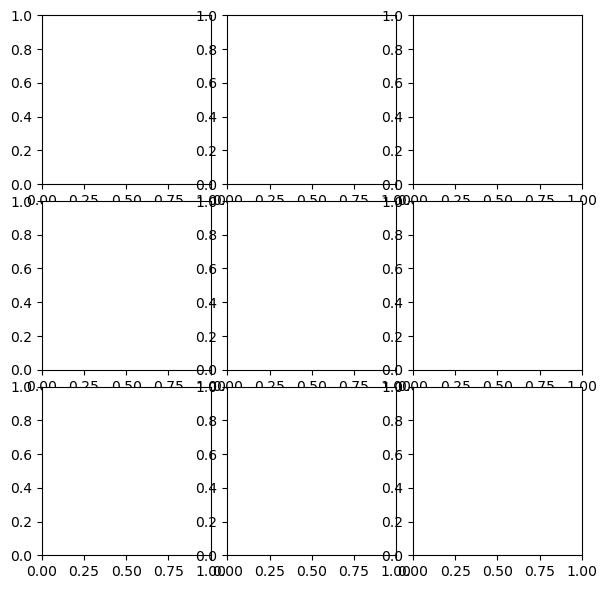

In [424]:
from skopt.plots import plot_objective
_ = plot_objective(bayes_search_estimator.optimizer_results_[0])
plt.show()


In [425]:
models[0].feature_names_in_

array(['building_id', 'type', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m',
       'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W',
       'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_s

In [426]:
models[0].best_estimator_.steps[0][1].get_feature_names_out().shape


(57,)

In [427]:
# get best model
models[0].best_estimator_.steps[-1][1].feature_importances_


array([9.08027839e-04, 1.34407350e-03, 8.75599854e-04, 8.51309397e-04,
       2.48186021e-03, 1.41431768e-03, 2.14506754e-07, 1.35501950e-03,
       2.70800766e-03, 8.76605714e-04, 1.46962321e-01, 1.29088159e-03,
       1.56120913e-03, 1.90647904e-01, 2.02426568e-05, 1.11671092e-09,
       2.14057116e-04, 1.10194761e-07, 9.53508269e-06, 4.95735542e-07,
       3.30265077e-05, 9.69415927e-04, 2.28434882e-03, 9.60352247e-04,
       9.53066846e-04, 5.29923572e-04, 1.41331819e-07, 5.54158520e-04,
       8.91315758e-04, 7.87642572e-04, 6.70260086e-06, 0.00000000e+00,
       1.22642687e-05, 5.05397543e-04, 1.43364246e-02, 9.03366224e-04,
       3.30841562e-04, 1.93938865e-03, 2.44768074e-03, 1.43520035e-03,
       1.73365008e-03, 2.60552325e-03, 2.16912901e-03, 4.28287795e-07,
       4.02688208e-01, 1.45857188e-03, 8.75776222e-04, 1.74809853e-03,
       1.56915762e-03, 9.47766027e-04, 5.05166669e-05, 7.03725440e-04,
       1.99903199e-01, 6.58410392e-05, 1.57302480e-05, 3.08764266e-05,
      

<Axes: >

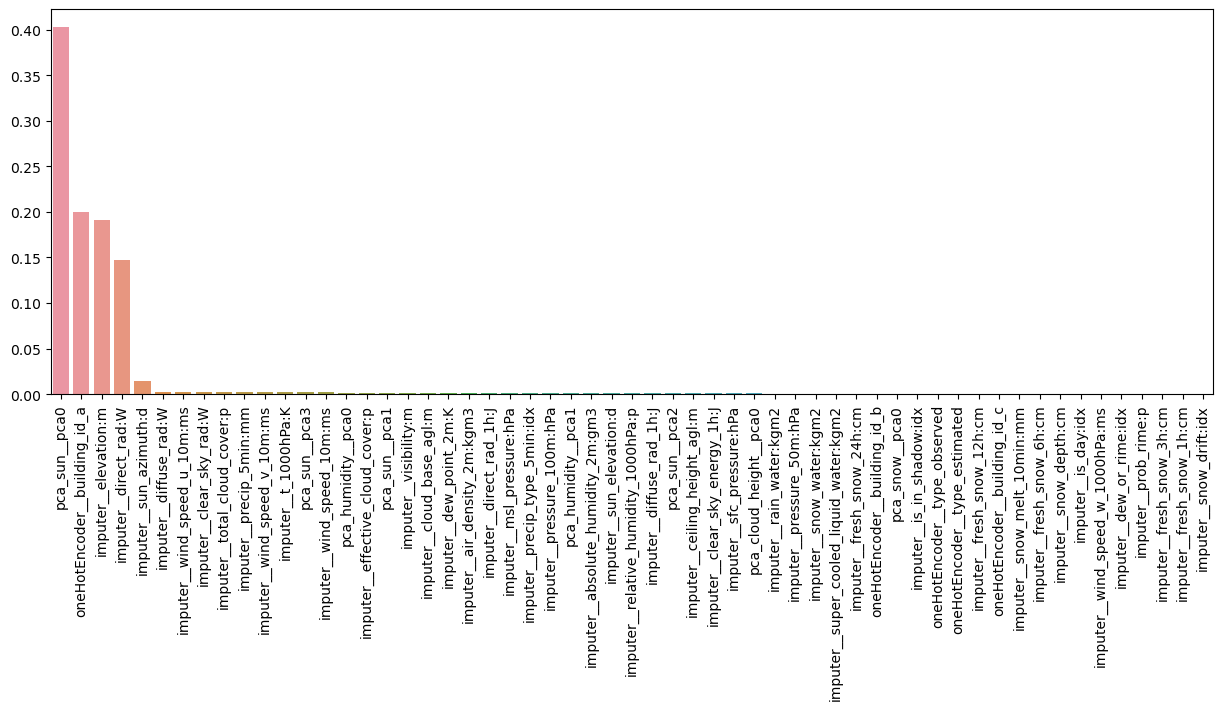

In [428]:
feature_names = models[0].best_estimator_.steps[0][1].get_feature_names_out()
feature_importances = models[0].best_estimator_.steps[-1][1].feature_importances_

feature_importance_series = pd.Series(
    data=feature_importances,
    index=feature_names
).sort_values(ascending=False)

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)

sns.barplot(
    x=feature_importance_series.index,
    y=feature_importance_series.values
)

In [429]:
pd.DataFrame(models[0].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columnTransformer__pca_sun__pca__n_components,param_estimator__max_depth,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,70.721937,0.054251,0.132086,0.019301,2,8,187,{'columnTransformer__pca_sun__pca__n_component...,-95.376409,-94.066740,-97.937747,-95.793632,1.607634,3
1,31.157841,0.029356,0.061854,0.001837,4,9,68,{'columnTransformer__pca_sun__pca__n_component...,-93.030537,-91.793864,-95.991858,-93.605420,1.761374,1
2,12.091623,0.414329,0.050978,0.010608,2,9,30,{'columnTransformer__pca_sun__pca__n_component...,-93.708300,-92.214442,-96.380778,-94.101173,1.723437,2
3,20.034671,0.026680,0.063872,0.007993,3,3,124,{'columnTransformer__pca_sun__pca__n_component...,-131.759470,-132.028040,-136.239093,-133.342201,2.051344,5
4,36.441769,0.056444,0.074678,0.013278,3,6,110,{'columnTransformer__pca_sun__pca__n_component...,-102.697651,-101.432879,-105.116821,-103.082450,1.528378,4


In [430]:
models[0].predict(X_test)

array([0.14592958, 0.14592958, 0.14592958, ..., 3.62925515, 0.16038852,
       0.16038852])

In [431]:
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
test['prediction'] = models[0].predict(X_test_aggregated)
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('hyper_forest.csv', index=False)